# Sentiment Analysis using BERT


### Import Libraries and Set the intial variables

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.empty_cache()

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

### Load the data

In [3]:
p_df = pd.read_csv("datasets/positive_user.csv")
n_df = pd.read_csv("datasets/negative_user.csv")

In [4]:
#p_df = p_df.iloc[:450000]
n_df = n_df.iloc[:len(p_df)]
n_df = n_df.groupby('user')['text'].agg(list).reset_index()
p_df = p_df.groupby('user')['text'].agg(list).reset_index()[:len(n_df)]
p_df["label"] = [1] * len(p_df)
n_df["label"] = [0] * len(n_df)
df = pd.concat([p_df, n_df])

In [5]:
df.columns = ['user','tweet','label']

In [6]:
assert df["tweet"].apply(lambda x: isinstance(x, list)).all() # make sure each element in tweet column is a list

In [7]:
class_names = ['not depressed', 'depressed']

## Data Preprocessing

Machine Learning models don’t work with raw text. You need to convert text to numerical representation. BERT requires even more attention when it comes to this representation.

Here are the requirements:

* Add special tokens to separate sentences and do classification
* Pass sequences of constant length (introduce padding)
* Create array of 0s (pad token) and 1s (real token) called attention mask

BERT offers a few model architectures and I will be using one of them combined with manual preprocessing. I am using the cased version which considers GREAT and great to be to different entities and BAD might be given more focus than bad.  

The tokenizer will break the sentence into words and give numerical values to each word.

In [8]:
# Set the model name
MODEL_NAME = 'prajjwal1/bert-tiny'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, force_download=True)

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [9]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review.

In [10]:
MAX_TWEETs = 50
MAX_LEN = 100

In [11]:
tweets = []

for tweet_list in df['tweet'].values:
  if len(tweet_list) < MAX_TWEETs:
    tweet_list.extend([""] * (MAX_TWEETs - len(tweet_list)))
  elif len(tweet_list) > MAX_TWEETs:
    tweet_list = tweet_list[:MAX_TWEETs]
  tweets.append(tweet_list)
    
df['tweet'] = tweets

In [12]:
assert set([len(t) for t in df["tweet"]]) == {MAX_TWEETs} # make sure the length of each list in tweets column is MAX_TWEETs

### Preparing Torch Dataset

To enter data into a PyTorch, we need a more robust data generator class. We will return the review text as well to validate our predictions easily.

In [13]:
class GPReviewDataset(Dataset):
    # Constructor Function
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    # Length magic method
    def __len__(self):
        return len(self.reviews)

    # get item magic method
    def __getitem__(self, item):
        review = self.reviews[item]
        target = self.targets[item]
        
        # Encoded format to be returned
        encoding = [
            self.tokenizer.encode_plus(
                x,
                add_special_tokens=True,
                max_length=self.max_len,
                return_token_type_ids=False,
                pad_to_max_length=True,
                return_attention_mask=True,
                return_tensors='pt',
            ) for x in review
        ]
        
        if len(encoding) > MAX_TWEETs:
            encoding = encoding[:MAX_TWEETs]

        return {
            'review_text': review,
            'input_ids': [x['input_ids'].flatten() for x in encoding],
            'attention_mask': [x['attention_mask'].flatten() for x in encoding],
            'targets': torch.tensor(target, dtype=torch.long)
        }

Create a 80% train data and 10% test and 10% validation data

In [14]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(1310, 3) (164, 3) (164, 3)


Create a dataloader to release data in batches.

In [15]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.tweet.to_numpy(),
        targets=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [16]:
BATCH_SIZE = 8

# row # must be multiple of BATCH_SIZE
df_train = df_train[:(len(df_train) // BATCH_SIZE) * BATCH_SIZE]
df_val = df_val[:(len(df_val) // BATCH_SIZE) * BATCH_SIZE]
df_test = df_test[:(len(df_test) // BATCH_SIZE) * BATCH_SIZE]

In [17]:
assert len(df_train) % BATCH_SIZE == 0
assert len(df_val) % BATCH_SIZE == 0
assert len(df_test) % BATCH_SIZE == 0

In [18]:
print(df_train.label.value_counts())
print(df_val.label.value_counts())
print(df_test.label.value_counts())

label
0    669
1    635
Name: count, dtype: int64
label
1    92
0    68
Name: count, dtype: int64
label
1    88
0    72
Name: count, dtype: int64


In [19]:
# Create train, test and val data loaders

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

## Sentiment Classification with BERT and Hugging Face

We’ll use the basic BertModel and build our sentiment classifier on top of it. Let’s load the model

In [20]:
# Load the basic BERT model
bert_model = BertModel.from_pretrained(MODEL_NAME)

In [21]:
# Build the Sentiment Classifier class
class SentimentClassifier(nn.Module):

    # Constructor class
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.lstm = nn.LSTM(input_size=128, hidden_size=50, num_layers=1, batch_first=True)
        self.out = nn.Linear(self.lstm.hidden_size, 1)

    # Forward propagation class
    def forward(self, input_ids, attention_mask):
        pooled_output = torch.zeros((BATCH_SIZE, MAX_TWEETs, 128), dtype=torch.float32)
        for x in range(0 , len(input_ids)):
            _, output = self.bert(input_ids=input_ids[x], attention_mask=attention_mask[x], return_dict=False)
            pooled_output[:, x].copy_(output)

        lstmOut, _ = self.lstm(pooled_output.view(BATCH_SIZE, MAX_TWEETs, 128))
        lstmOut = lstmOut[:, -1, :]
        
        return torch.sigmoid(self.out(lstmOut))

We use a dropout layer for some regularization and a fully-connected layer for our output. We are returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work. Create an instance and move it to the GPU

In [22]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

#### Model Characterstics

In [23]:
# Number of hidden units
print(bert_model.config.hidden_size)

128


### Training Phase

we’ll use the AdamW optimizer provided by Hugging Face. It corrects weight decay. We’ll also use a linear scheduler with no warmup

In [24]:
torch.set_default_device("cuda" if torch.cuda.is_available() else "cpu")  # only use cuda for training

In [25]:
# Number of iterations
EPOCHS = 20

# Optimizer Adam
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS
'''
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
'''
scheduler = OneCycleLR(optimizer, max_lr = .001, total_steps = total_steps)
# Set the loss function
loss_fn = nn.BCELoss().to(device)

In [30]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples, progress_bar=None):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = torch.stack(d["input_ids"]).to(device)
        attention_mask = torch.stack(d["attention_mask"]).to(device)
        targets = d["targets"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        outputs = outputs.view(-1, 1).float()
        targets = targets.view(-1, 1).float()

        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(outputs.round() == targets)
        losses.append(loss.item())
        # Backward prop
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.2)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad(set_to_none=True)

        if progress_bar:
            progress_bar.update(1)

    return correct_predictions.double() / n_examples, np.mean(losses)

Write a function to evaluate model performance

In [31]:
def eval_model(model, data_loader, loss_fn, device, n_examples, progress_bar=None):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = torch.stack(d["input_ids"]).to(device)
            attention_mask = torch.stack(d["attention_mask"]).to(device)
            targets = d["targets"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            outputs = outputs.view(-1, 1).float()
            targets = targets.view(-1, 1).float()

            #print("OUTPUT", outputs)
            #print("TARGET", targets)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(outputs.round() == targets)
            losses.append(loss.item())

            if progress_bar:
                progress_bar.update(1)
                
    return correct_predictions.double() / n_examples, np.mean(losses)

In [32]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, element

In [33]:
%%time


from tqdm import tqdm

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    # Show details
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)


    train_progress_bar = tqdm(total=len(train_data_loader), desc="Training", position=0, leave=True)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train),
        train_progress_bar
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")


    val_progress_bar = tqdm(total=len(val_data_loader), desc="Validation", position=0, leave=True)

    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val),
        val_progress_bar
    )

    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/20
----------


Training: 100%|███████████████████████████████| 163/163 [00:57<00:00,  2.91it/s]

Train loss 0.6888169580442043 accuracy 0.5383435582822086


Validation: 100%|███████████████████████████████| 20/20 [00:04<00:00,  4.45it/s]

Val   loss 0.6417236775159836 accuracy 0.70625

Epoch 2/20
----------


Training: 100%|███████████████████████████████| 163/163 [00:54<00:00,  3.09it/s]

Train loss 0.620217092289515 accuracy 0.6533742331288344


Validation: 100%|███████████████████████████████| 20/20 [00:04<00:00,  4.48it/s]

Val   loss 0.5026469200849533 accuracy 0.78125

Epoch 3/20
----------


Training: 100%|███████████████████████████████| 163/163 [00:54<00:00,  2.93it/s]

Train loss 0.47835392834035895 accuracy 0.7898773006134969


Validation: 100%|███████████████████████████████| 20/20 [00:04<00:00,  4.02it/s]

Val   loss 0.48620954602956773 accuracy 0.75

Epoch 4/20
----------


Training: 100%|███████████████████████████████| 163/163 [00:54<00:00,  2.82it/s]

Train loss 0.3250397384920917 accuracy 0.8872699386503068


Validation: 100%|███████████████████████████████| 20/20 [00:04<00:00,  4.05it/s]

Val   loss 0.5706162430346012 accuracy 0.8

Epoch 5/20
----------


Training: 100%|███████████████████████████████| 163/163 [00:54<00:00,  3.06it/s]

Train loss 0.32917635521045857 accuracy 0.8895705521472392


Validation: 100%|███████████████████████████████| 20/20 [00:04<00:00,  4.44it/s]

Val   loss 0.7749849073588848 accuracy 0.70625

Epoch 6/20
----------


Training: 100%|███████████████████████████████| 163/163 [00:53<00:00,  3.10it/s]

Train loss 0.32888259691260524 accuracy 0.8880368098159509


Validation: 100%|███████████████████████████████| 20/20 [00:04<00:00,  4.46it/s]

Val   loss 0.8838055822998285 accuracy 0.7312500000000001

Epoch 7/20
----------


Training: 100%|███████████████████████████████| 163/163 [00:54<00:00,  2.87it/s]

Train loss 0.2989747845424922 accuracy 0.9095092024539877


Validation: 100%|███████████████████████████████| 20/20 [00:04<00:00,  4.40it/s]

Val   loss 0.7309124432504177 accuracy 0.75

Epoch 8/20
----------


Training: 100%|███████████████████████████████| 163/163 [00:53<00:00,  3.05it/s]

Train loss 0.2804939103787022 accuracy 0.9171779141104295


Validation: 100%|███████████████████████████████| 20/20 [00:04<00:00,  4.45it/s]

Val   loss 0.9409790139179677 accuracy 0.76875

Epoch 9/20
----------


Training: 100%|███████████████████████████████| 163/163 [00:53<00:00,  3.07it/s]

Train loss 0.2508457401828795 accuracy 0.9348159509202454


Validation: 100%|███████████████████████████████| 20/20 [00:04<00:00,  4.41it/s]

Val   loss 0.6389961270615458 accuracy 0.8

Epoch 10/20
----------


Training: 100%|███████████████████████████████| 163/163 [00:54<00:00,  2.93it/s]

Train loss 0.2283359405590347 accuracy 0.9363496932515337


Validation: 100%|███████████████████████████████| 20/20 [00:04<00:00,  4.44it/s]

Val   loss 0.8672198594547809 accuracy 0.76875

Epoch 11/20
----------


Training: 100%|███████████████████████████████| 163/163 [00:54<00:00,  3.09it/s]

Train loss 0.2549557292011161 accuracy 0.9325153374233129


Validation: 100%|███████████████████████████████| 20/20 [00:04<00:00,  4.48it/s]

Val   loss 0.8088502251543105 accuracy 0.7937500000000001

Epoch 12/20
----------


Training: 100%|███████████████████████████████| 163/163 [00:53<00:00,  3.08it/s]

Train loss 0.17459537371945927 accuracy 0.9516871165644172


Validation: 100%|███████████████████████████████| 20/20 [00:04<00:00,  4.45it/s]

Val   loss 0.9452422659960575 accuracy 0.8125

Epoch 13/20
----------


Training: 100%|███████████████████████████████| 163/163 [00:53<00:00,  3.09it/s]

Train loss 0.13537147187590715 accuracy 0.963957055214724


Validation: 100%|███████████████████████████████| 20/20 [00:04<00:00,  4.54it/s]

Val   loss 0.9919866777141578 accuracy 0.8187500000000001

Epoch 14/20
----------


Training: 100%|███████████████████████████████| 163/163 [00:53<00:00,  3.09it/s]

Train loss 0.09195639225554315 accuracy 0.9754601226993865


Validation: 100%|███████████████████████████████| 20/20 [00:04<00:00,  4.47it/s]

Val   loss 1.2064593288348988 accuracy 0.775

Epoch 15/20
----------


Training: 100%|███████████████████████████████| 163/163 [00:53<00:00,  3.07it/s]

Train loss 0.05566561415875788 accuracy 0.9861963190184049


Validation: 100%|███████████████████████████████| 20/20 [00:04<00:00,  4.46it/s]

Val   loss 1.3820602649007925 accuracy 0.76875

Epoch 16/20
----------


Training: 100%|███████████████████████████████| 163/163 [00:53<00:00,  3.08it/s]

Train loss 0.03205418339509094 accuracy 0.99079754601227


Validation: 100%|███████████████████████████████| 20/20 [00:04<00:00,  4.36it/s]

Val   loss 1.4540489313891158 accuracy 0.7312500000000001

Epoch 17/20
----------


Training: 100%|███████████████████████████████| 163/163 [00:54<00:00,  3.00it/s]

Train loss 0.0297731602789607 accuracy 0.9930981595092024


Validation: 100%|███████████████████████████████| 20/20 [00:04<00:00,  4.50it/s]

Val   loss 1.3910925271222367 accuracy 0.74375

Epoch 18/20
----------


Training: 100%|███████████████████████████████| 163/163 [00:53<00:00,  3.06it/s]

Train loss 0.0195016800147407 accuracy 0.9969325153374233


Validation: 100%|███████████████████████████████| 20/20 [00:04<00:00,  4.08it/s]

Val   loss 1.3487277406500653 accuracy 0.7625000000000001

Epoch 19/20
----------


Training: 100%|███████████████████████████████| 163/163 [00:54<00:00,  3.08it/s]

Train loss 0.0223204802888327 accuracy 0.995398773006135


Validation: 100%|███████████████████████████████| 20/20 [00:04<00:00,  4.45it/s]

Val   loss 1.31582752764225 accuracy 0.76875

Epoch 20/20
----------


Training:  11%|███▎                          | 18/163 [19:46<2:39:20, 65.94s/it]


ValueError: Tried to step 3261 times. The specified number of total steps is 3260

The above took a lot of time but it's finally working. Now, we can plot the training and validation accuracy.

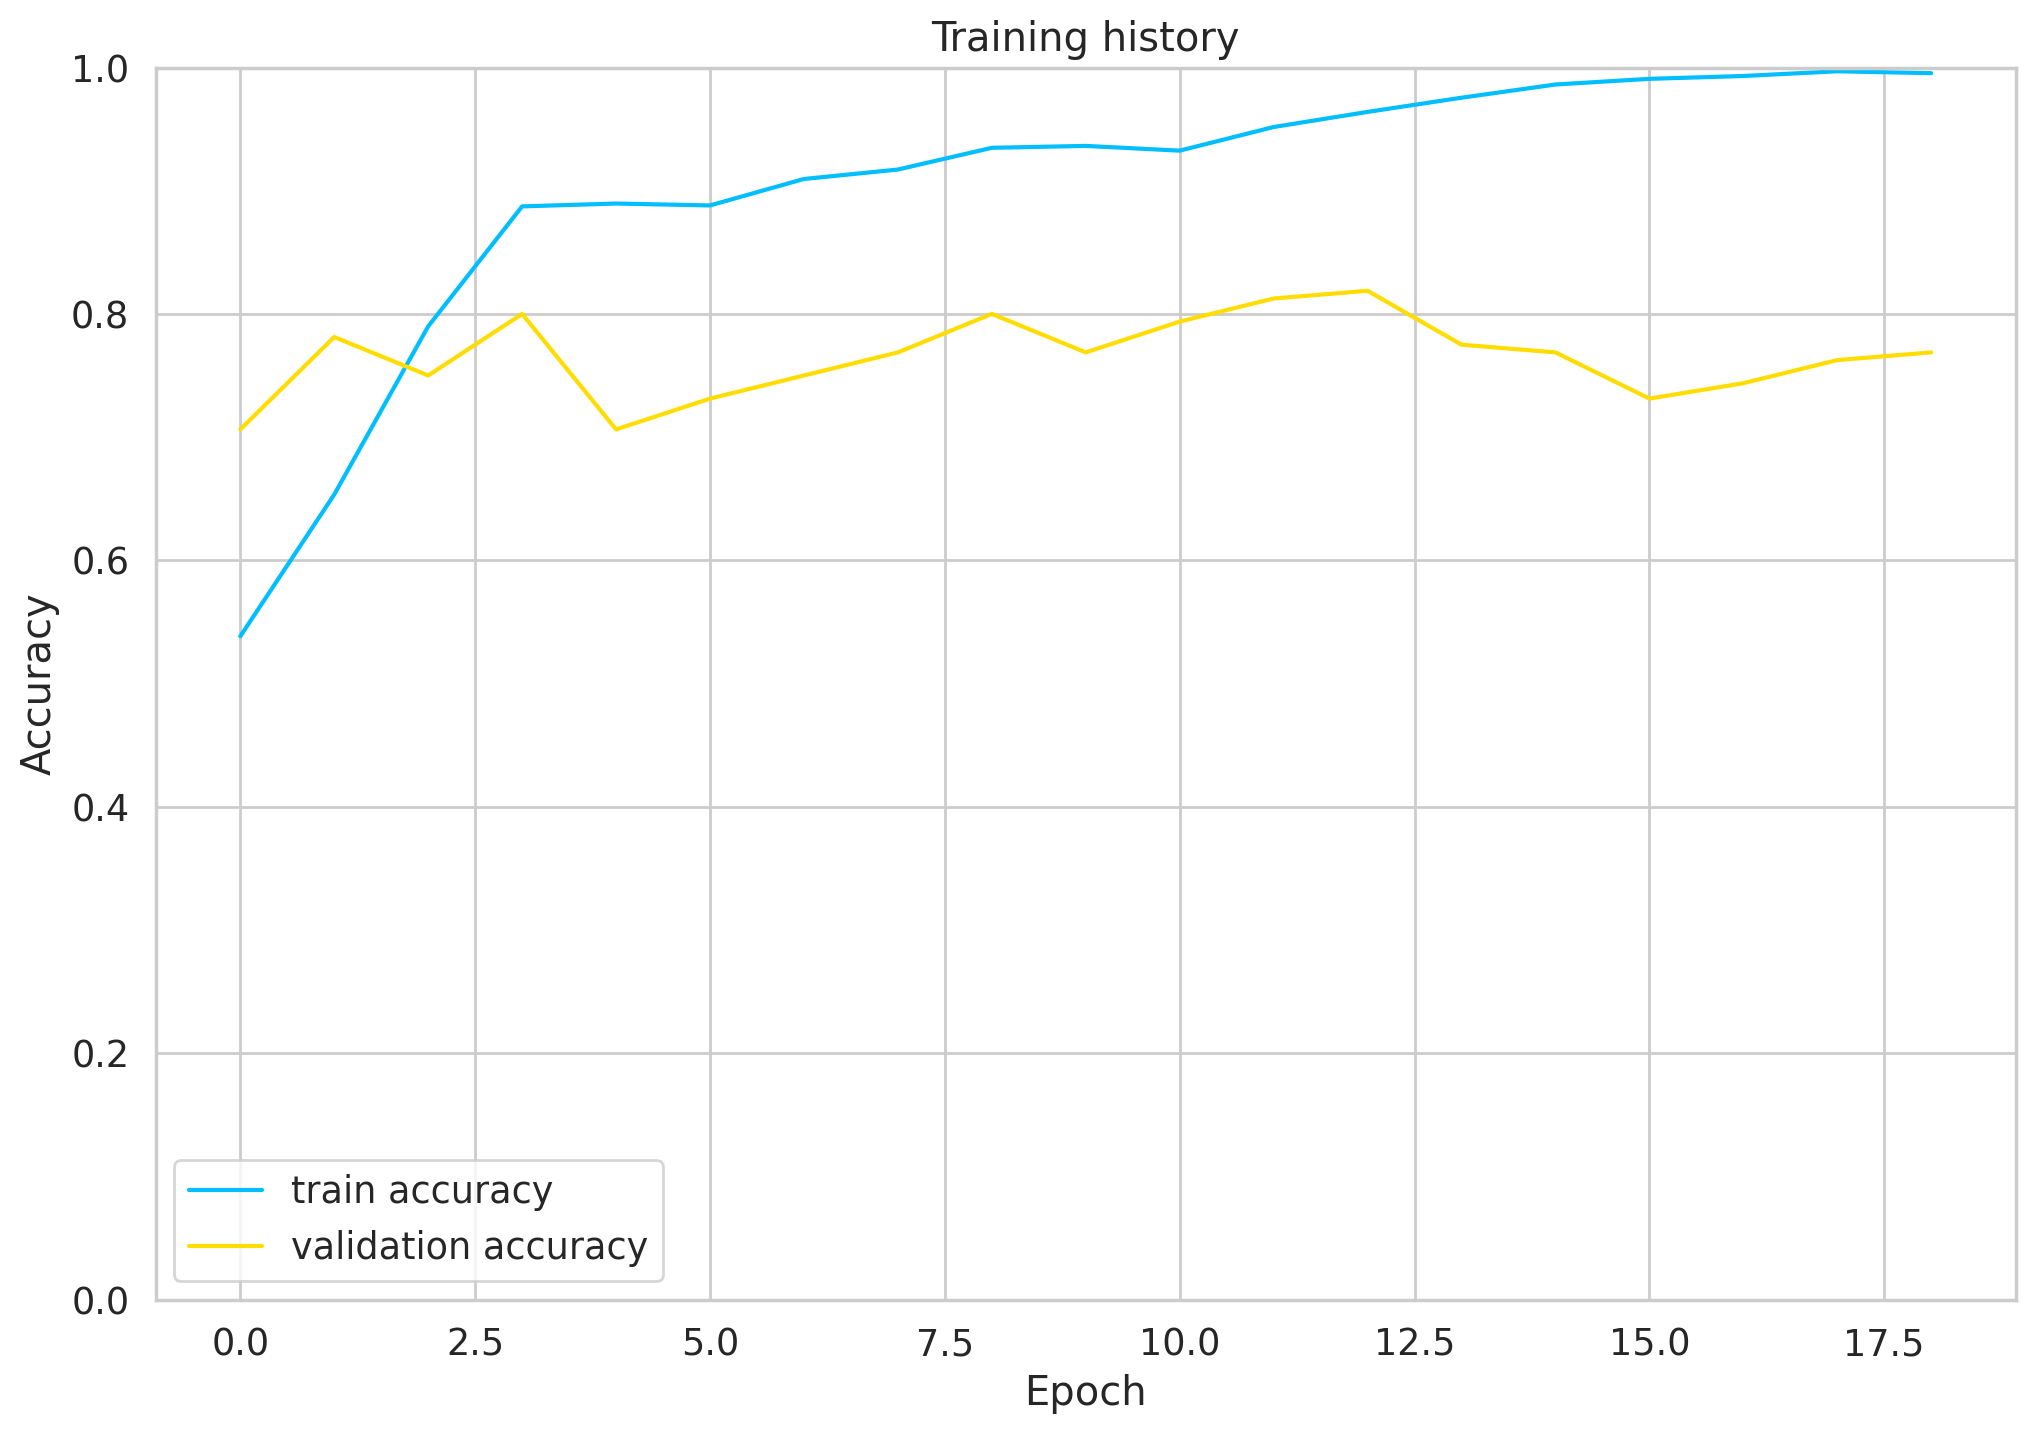

In [34]:
# Plot training and validation accuracy
plt.plot(list(map(lambda x: x.cpu(), history['train_acc'])), label='train accuracy')
plt.plot(list(map(lambda x: x.cpu(), history['val_acc'])), label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Model Evaluation

In [42]:
best = torch.load("best_model_state.bin")

model = SentimentClassifier(len(class_names))
model.load_state_dict(best)



<All keys matched successfully>

In [43]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.7312500000000001

In [44]:
test_data_loader.dataset.targets

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0])

Define a helper function to get predictions from our models. This is similar to the evaluation function, except that we’re storing the text of the reviews and the predicted probabilities

In [45]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = [x.to(device) for x in d["input_ids"]]
            attention_mask = [x.to(device) for x in d["attention_mask"]]
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            preds = torch.flatten(outputs.round())

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [49]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [50]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

not depressed       0.72      0.65      0.69        72
    depressed       0.74      0.80      0.77        88

     accuracy                           0.73       160
    macro avg       0.73      0.72      0.73       160
 weighted avg       0.73      0.73      0.73       160



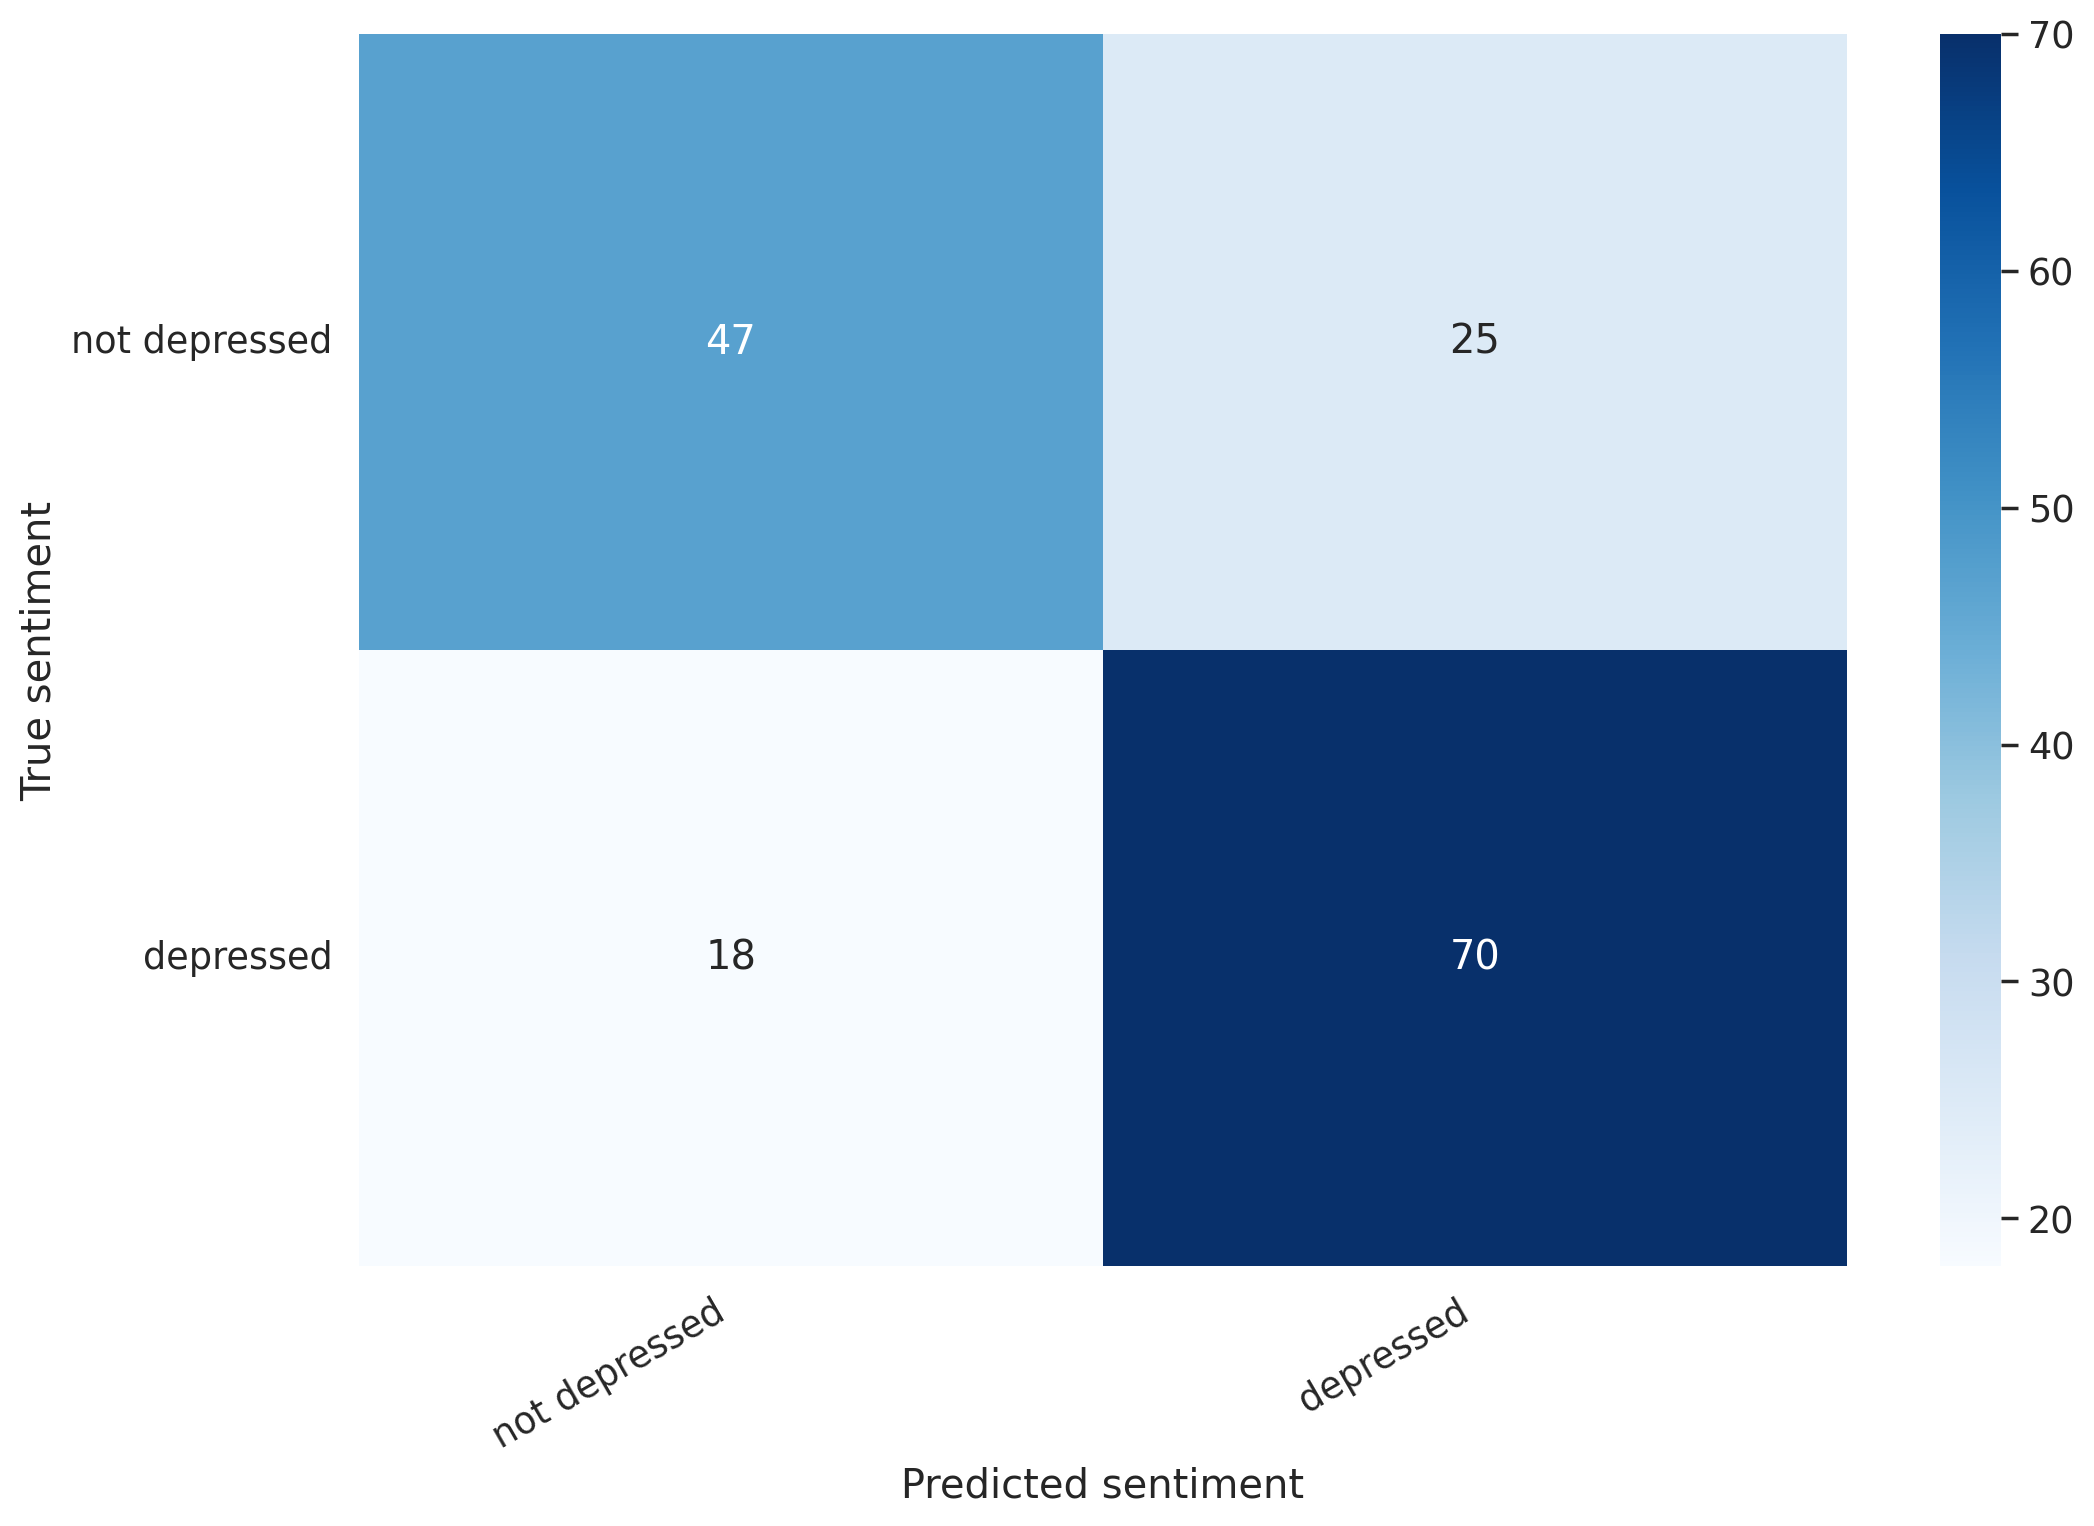

In [48]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [40]:
torch.save(model.state_dict(), "LESSGOOOOO.pt")

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That’s a good overview of the performance of our model.

## Predicting on raw text

In [ ]:
review_text = "I have depression h"

In [ ]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)


In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

In [ ]:
torch.save(model.state_dict(), "model.pt")

In [ ]:
model = torch.load("model.pt", map_location=torch.device('cpu'))

print(type(model))

In [ ]:

model = SentimentClassifier(len(class_names))
model.load_state_dict(test)

